## **Project 7: Computer Vision (CNN)**

<hr>

**Name:** Adam DiStefano

**Date:** October 2022

**Background and Context**

Covid-19 is a fast-growing disease that affects human health severely. Patients diagnosed with this
condition suffer from lung infections. The medical community has recently released vaccines that have
a slower effect in increasing immunity. This virus has impacted various countries' human health and
financial standards.

Deep learning algorithms have recently used image classification to identify medical images.
Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists
in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by
COVID using X-ray pictures of the lungs.

**Objective**

The aim of this project is to build a Convolutional Neural Network to differentiate an X-ray image of a
normal person from an unhealthy one.

**Data Description**

* This dataset contains training set images of 3 classes which are converted into numpy
arrays.
* The dataset comprises 3 classes:
     * **COVID-19:** The patient who is affected due to covid
     * **Viral Pneumonia:** This is a viral fever that has similar characteristics to Covid
but is not covid.
     * **Normal:** A healthy Person.

## **Import Libraries**

In [68]:
#Importing modules
import os
import numpy as np                                                                               
import pandas as pd                                                                              
import matplotlib.pyplot as plt                                                                  
import math                                                                                      
import cv2                                                                                       
import seaborn as sns
import random
import warnings                                                                 

#Tensorflow Modules
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model                                                 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses, optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from keras.callbacks import ReduceLROnPlateau

#Importing sklearn Modules
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix 

## **Load Dataset**

In [2]:
#Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')
#Load Images
images = np.load('/content/drive/My Drive/Colab Notebooks/Covid_Images_.npy')
#Load Labels
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Covid_Labels_.csv')

Mounted at /content/drive


**Overview of the Dataset**

In [3]:
#Print shape of images
print(images.shape)
#print shape of labels
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


**Observations**

There are 251 RGB images of shape 128 x 128 x 3 as each shape is an RGB image making up (3) channels. There are 251 rows and one column representing the labels.

In [4]:
#Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

**EDA**

In [5]:
#Function to plot images
def plot_images(images,labels):
  #Number of Classes
  num_classes = 10                                                                  
  categories = np.unique(labels)   
  #Obtain unique classes from y_train
  keys = dict(labels['Label'])  
  #Show 3 rows
  rows = 3 
  #Show 4 columns                                                                     
  cols = 4
  #Make figure size to 10 x 8                                                                     
  fig = plt.figure(figsize=(10, 8))                                               
  for i in range(cols):
      for j in range(rows):
          #Generate random indices from the data and plotting the images
          random_index = np.random.randint(0, len(labels)) 
          #Add subplots with 3 rows and 4 columns                       
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          #Plot image                     
          ax.imshow(images[random_index, :])                                       
          ax.set_title(keys[random_index])
  plt.show()

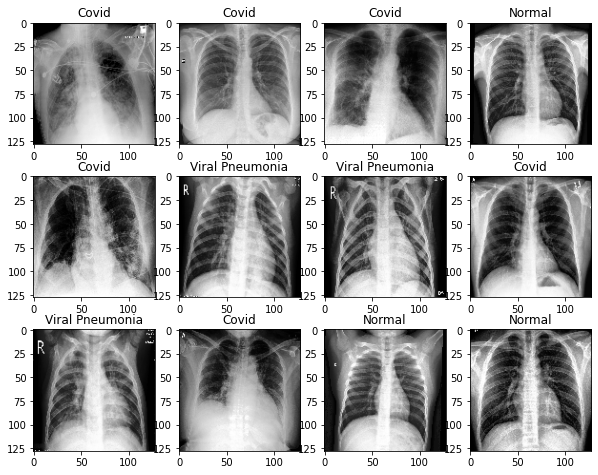

In [6]:
#Show images
plot_images(images,labels)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

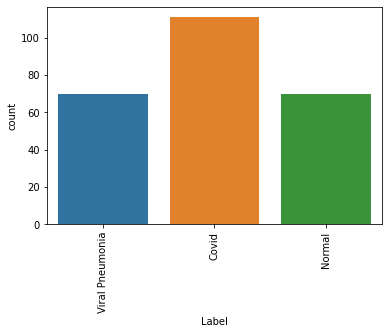

In [7]:
#Review Data Imbalances
warnings.filterwarnings("ignore")
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

**Observations**

We can see that viral pneumonia and normal lungs are almost perfectly equal in the dataset. Covid images make up the most represented in the dataset.

In [8]:
#Reducing the image sizes from 128 to 64 for faster computation
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

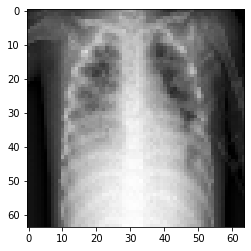

In [9]:
#Show a sample of reduced image
plt.imshow(images_decreased[4])

**Splitting the Dataset**

As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.

In [10]:
#Splitting the dataset into train, test, and validation
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [11]:
#Printing the shapes of train, test, validate
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(202, 64, 64, 3) (202, 1)
(23, 64, 64, 3) (23, 1)
(26, 64, 64, 3) (26, 1)


**Observations**

* **Train:** 202 images of size 64 x 64 x 3
* **Test:** 23 images of size 64 x 64 x 3
* **Validate:** 26 images of size 64 x 64 x 3

In [12]:
#Encoding target labels
encoded = LabelBinarizer()
y_train_encoded = encoded.fit_transform(y_train)
y_val_encoded = encoded.transform(y_val)
y_test_encoded = encoded.transform(y_test)

In [13]:
#Review shape of encoded target variables
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((202, 3), (23, 3), (26, 3))

**Observations**

* **Train:** 202 images with 3 labels
* **Test:** 23 images with 3 labels
* **Validate:** 26 images with 3 labels

By dividing the pixels by 255, we will standarize the images to be between the values of 0-1.

In [14]:
#Normalize the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Convolutional Neural Network (CNN) Model Building**

Seeding for random number generator in NumPy and TensorFlow to be able to reproduce the same results every time code is executed.

In [15]:
#Seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Clear the backend

In [16]:
#Clear backend
backend.clear_session()

In [17]:
#Intializing a sequential model
model = Sequential()

#Pad for 'same' to provide the output size same as the input size
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64,64,3)))

#Add max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

#Flatten output of the conv layer after max pooling
model.add(Flatten())

#Add  fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))

#Add the output layer activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(3, activation='softmax'))

#SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

#Compiling the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Generate summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [18]:
#Fit the model
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
7/7 - 9s - loss: 1.0755 - accuracy: 0.4406 - val_loss: 1.0264 - val_accuracy: 0.4348 - 9s/epoch - 1s/step
Epoch 2/30
7/7 - 0s - loss: 0.9903 - accuracy: 0.4604 - val_loss: 0.8812 - val_accuracy: 0.6522 - 62ms/epoch - 9ms/step
Epoch 3/30
7/7 - 0s - loss: 0.7347 - accuracy: 0.7178 - val_loss: 1.2098 - val_accuracy: 0.5217 - 62ms/epoch - 9ms/step
Epoch 4/30
7/7 - 0s - loss: 0.7960 - accuracy: 0.7030 - val_loss: 0.5631 - val_accuracy: 0.6957 - 64ms/epoch - 9ms/step
Epoch 5/30
7/7 - 0s - loss: 0.5492 - accuracy: 0.7673 - val_loss: 0.4058 - val_accuracy: 0.9565 - 62ms/epoch - 9ms/step
Epoch 6/30
7/7 - 0s - loss: 0.4027 - accuracy: 0.8416 - val_loss: 0.6104 - val_accuracy: 0.6522 - 65ms/epoch - 9ms/step
Epoch 7/30
7/7 - 0s - loss: 0.5591 - accuracy: 0.7723 - val_loss: 0.4373 - val_accuracy: 0.8261 - 64ms/epoch - 9ms/step
Epoch 8/30
7/7 - 0s - loss: 0.3351 - accuracy: 0.9109 - val_loss: 0.2439 - val_accuracy: 0.9565 - 66ms/epoch - 9ms/step
Epoch 9/30
7/7 - 0s - loss: 0.2474 - accura

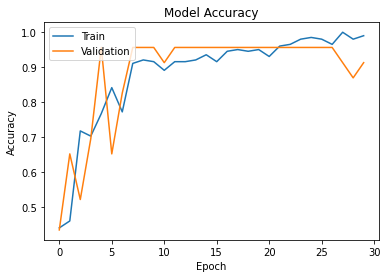

In [19]:
#Plot Model Accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
#Accuracy evaluation on training data for Model 1
accuracy = model.evaluate(X_train_normalized, y_train_encoded, verbose=2)

7/7 - 0s - loss: 0.0299 - accuracy: 0.9901 - 57ms/epoch - 8ms/step


**Observations**

Accuracy is 99% on training data.

In [22]:
accuracy = model.evaluate(X_val_normalized, y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.3726 - accuracy: 0.9130 - 25ms/epoch - 25ms/step


**Observations**

Accuracy is 91% on validation data.

In [23]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 0.1242 - accuracy: 0.9231 - 123ms/epoch - 123ms/step


**Observations**

Accuracy is 92% on test data.

1/1 [==============================] - 0s 25ms/step


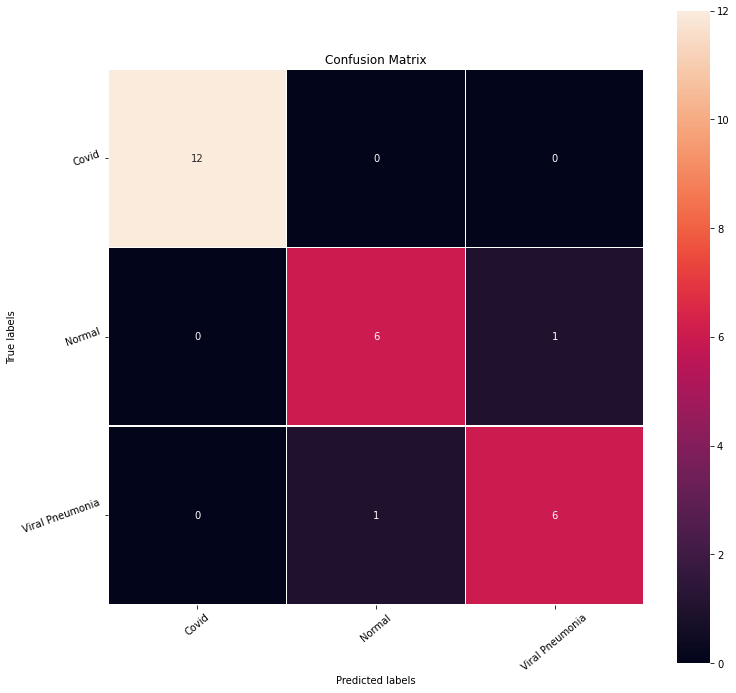

In [25]:
#Return output as probablities for each category
y_pred=model.predict(X_test_normalized)

#Get the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

#Plot Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
#Set the labels
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(encoded.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(encoded.classes_),rotation=20)
plt.show()

**Observations**

* Predicted Covid and Was Covid: 12
* Predicted Covid and Was Not Covid: 0

In [26]:
#Accuracy as per the classification report 
cr = metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.86      0.86      0.86         7
           2       0.86      0.86      0.86         7

    accuracy                           0.92        26
   macro avg       0.90      0.90      0.90        26
weighted avg       0.92      0.92      0.92        26



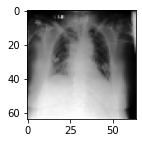

1/1 [==============================] - 0s 15ms/step
Predicted Label ['Covid']
True Label Covid


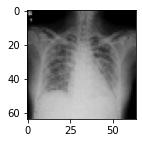

1/1 [==============================] - 0s 15ms/step
Predicted Label ['Covid']
True Label Covid


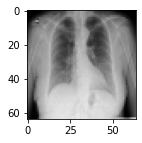

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Covid']
True Label Covid


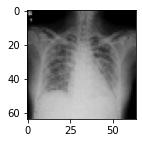

1/1 [==============================] - 0s 17ms/step
Predicted Label ['Covid']
True Label Covid


In [29]:
#Visualize predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', encoded.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[2])                                               

plt.figure(figsize=(2,2))
plt.imshow(X_test[3])
plt.show()
print('Predicted Label', encoded.inverse_transform(model.predict((X_test_normalized[3].reshape(1,64,64,3)))))  
print('True Label', encoded.inverse_transform(y_test_encoded)[3])                                             

plt.figure(figsize=(2,2))
plt.imshow(X_test[5],)
plt.show()
print('Predicted Label', encoded.inverse_transform(model.predict((X_test_normalized[5].reshape(1,64,64,3)))))  
print('True Label', encoded.inverse_transform(y_test_encoded)[5])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[3])
plt.show()
print('Predicted Label', encoded.inverse_transform(model.predict((X_test_normalized[3].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[6])                                           

**Model 2: Data Augmentation**

In [ ]:
#Clearing backend
backend.clear_session()

In [30]:
#Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [38]:
#Set Learning Rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [39]:
#ImageDataGenerator
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )

In [40]:
#Intializing a sequential model
model2 = Sequential()

#Pad for 'same' to provide the output size same as the input size
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

#Add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Flatten output of the conv layer after max pooling
model2.add(Flatten())

#Add dense layer with 100 neurons    
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))

#Add 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model2.add(Dense(3, activation='softmax'))

#SGD Optimizer
opt=Adam()

#Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Generate the summary
model2.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [55]:
#Epochs
epochs = 30

#Batch size
batch_size = 64

#Fit the model
history_2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=2,callbacks=[learning_rate_reduction])

Epoch 1/30
3/3 - 0s - loss: 0.2561 - accuracy: 0.9130 - val_loss: 0.4668 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 239ms/epoch - 80ms/step
Epoch 2/30
3/3 - 0s - loss: 0.2747 - accuracy: 0.8913 - val_loss: 0.4633 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 211ms/epoch - 70ms/step
Epoch 3/30
3/3 - 0s - loss: 0.2915 - accuracy: 0.8802 - val_loss: 0.4595 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 254ms/epoch - 85ms/step
Epoch 4/30
3/3 - 0s - loss: 0.2587 - accuracy: 0.9275 - val_loss: 0.4568 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 216ms/epoch - 72ms/step
Epoch 5/30
3/3 - 0s - loss: 0.2543 - accuracy: 0.9219 - val_loss: 0.4524 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 262ms/epoch - 87ms/step
Epoch 6/30
3/3 - 0s - loss: 0.2576 - accuracy: 0.9058 - val_loss: 0.4476 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 206ms/epoch - 69ms/step
Epoch 7/30
3/3 - 0s - loss: 0.3084 - accuracy: 0.8913 - val_loss: 0.4444 - val_accuracy: 0.7826 - lr: 1.0000e-05 - 256ms/epoch - 85ms/step
Epoch 8/30
3/3 - 0s - loss:

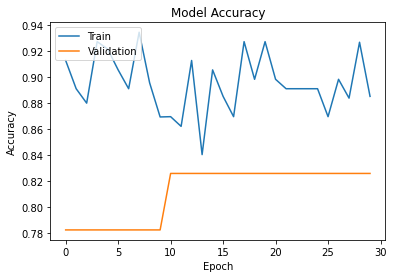

In [76]:
#Plot Model Accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [57]:
accuracy = model2.evaluate(X_train_normalized, y_train_encoded, verbose=2)

7/7 - 0s - loss: 0.3437 - accuracy: 0.8663 - 40ms/epoch - 6ms/step


**Observations**

Accuracy is approx. 87% on training data.

In [58]:
accuracy = model2.evaluate(X_val_normalized, y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.3686 - accuracy: 0.8261 - 19ms/epoch - 19ms/step


**Observations**

Accuracy is approx. 83% on validation data.

In [59]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 0.2714 - accuracy: 0.9231 - 19ms/epoch - 19ms/step


**Observations**

Accuracy is approx. 92% on test data.

1/1 [==============================] - 0s 41ms/step


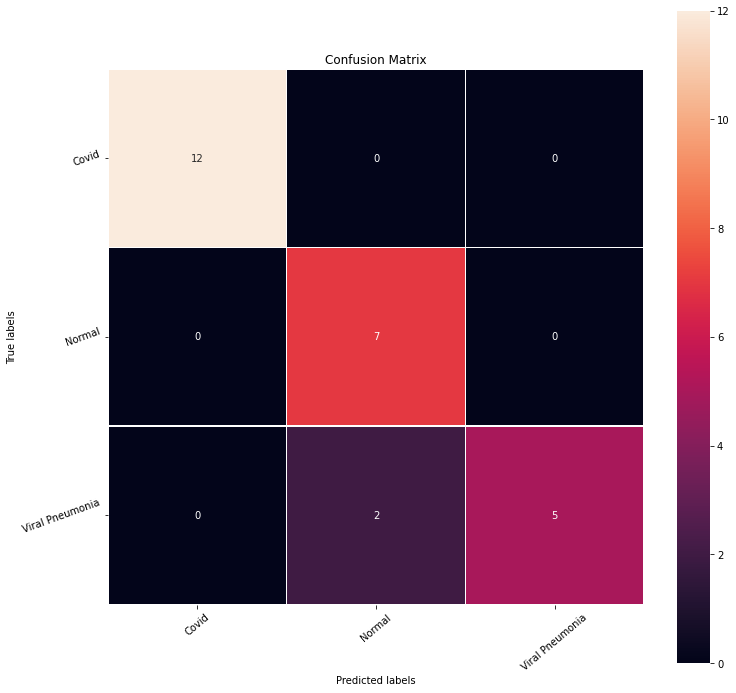

In [61]:
#Probablities for each category
y_pred=model2.predict(X_test_normalized)

#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

#Plot the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
#Set the labels
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(encoded.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(encoded.classes_),rotation=20)
plt.show()

**Observations**

* Predicted Covid and Was Covid: 12
* Predicted Covid and Was Not Covid: 0

In [63]:
#Accuracy as per the classification report 
cr = metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.78      1.00      0.88         7
           2       1.00      0.71      0.83         7

    accuracy                           0.92        26
   macro avg       0.93      0.90      0.90        26
weighted avg       0.94      0.92      0.92        26



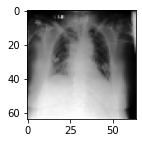

1/1 [==============================] - 0s 17ms/step
Predicted Label ['Covid']
True Label Covid


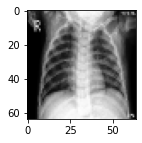

1/1 [==============================] - 0s 15ms/step
Predicted Label ['Viral Pneumonia']
True Label Viral Pneumonia


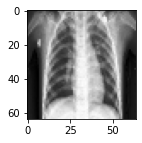

1/1 [==============================] - 0s 16ms/step
Predicted Label ['Normal']
True Label Viral Pneumonia


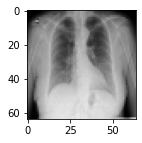

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Covid']
True Label Covid


In [69]:
#Visualize the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', encoded.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[2])                                             

plt.figure(figsize=(2,2))
plt.imshow(X_test[13])
plt.show()
print('Predicted Label', encoded.inverse_transform(model2.predict((X_test_normalized[13].reshape(1,64,64,3)))))  
print('True Label', encoded.inverse_transform(y_test_encoded)[13])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[23],)
plt.show()
print('Predicted Label', encoded.inverse_transform(model2.predict((X_test_normalized[23].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[23])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', encoded.inverse_transform(model2.predict((X_test_normalized[5].reshape(1,64,64,3)))))  
print('True Label', encoded.inverse_transform(y_test_encoded)[5])                                             

**Observations**

Here we see an image that was predicted as normal but was actually viral pneumonia.

**Model 3: Transfer Learning using VGG16**

In [70]:
#Clear backend
backend.clear_session()

In [71]:
#Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [72]:
#Import VGG16 Model with pretrained ImageNet weights
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))   
vgg_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [73]:
#Making layers of the VGG model non-trainable
for layer in vgg_model.layers:
    layer.trainable = False

In [74]:
#Build Model
model3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense layer
model3.add(Dense(32, activation='relu'))
# Adding droput layer with 0.2 dropout rate
model3.add(Dropout(0.2))
model3.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons
model3.add(Dense(3, activation='softmax'))
opt=Adam()
# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 14,780,835
Trainable params: 66,147
Non-tr

In [75]:
#Fit the model
history_3 = model3.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
7/7 - 3s - loss: 1.0441 - accuracy: 0.4109 - val_loss: 0.8453 - val_accuracy: 0.6522 - 3s/epoch - 466ms/step
Epoch 2/30
7/7 - 0s - loss: 0.7761 - accuracy: 0.7129 - val_loss: 0.6203 - val_accuracy: 0.6957 - 152ms/epoch - 22ms/step
Epoch 3/30
7/7 - 0s - loss: 0.5825 - accuracy: 0.7772 - val_loss: 0.5237 - val_accuracy: 0.8261 - 145ms/epoch - 21ms/step
Epoch 4/30
7/7 - 0s - loss: 0.5024 - accuracy: 0.7921 - val_loss: 0.4281 - val_accuracy: 0.8696 - 148ms/epoch - 21ms/step
Epoch 5/30
7/7 - 0s - loss: 0.4088 - accuracy: 0.8663 - val_loss: 0.3894 - val_accuracy: 0.8261 - 149ms/epoch - 21ms/step
Epoch 6/30
7/7 - 0s - loss: 0.3668 - accuracy: 0.8713 - val_loss: 0.3356 - val_accuracy: 0.8696 - 141ms/epoch - 20ms/step
Epoch 7/30
7/7 - 0s - loss: 0.3418 - accuracy: 0.8861 - val_loss: 0.3261 - val_accuracy: 0.9130 - 144ms/epoch - 21ms/step
Epoch 8/30
7/7 - 0s - loss: 0.3139 - accuracy: 0.9010 - val_loss: 0.2775 - val_accuracy: 0.9130 - 145ms/epoch - 21ms/step
Epoch 9/30
7/7 - 0s - loss

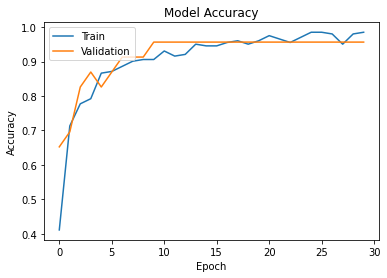

In [77]:
#Plot Model Accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [78]:
#Get accuracy of the model
accuracy = model3.evaluate(X_train_normalized, y_train_encoded, verbose=2)

7/7 - 0s - loss: 0.0546 - accuracy: 0.9851 - 159ms/epoch - 23ms/step


**Observations**

Accuracy is approx. 99% on training data.

In [79]:
#Get accuracy of the model
accuracy = model3.evaluate(X_val_normalized, y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.1790 - accuracy: 0.9565 - 36ms/epoch - 36ms/step


**Observations**

Accuracy is approx. 96% on validation data.

In [80]:
#Get accuracy of the model
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 1s - loss: 0.1710 - accuracy: 0.9231 - 508ms/epoch - 508ms/step


**Observations**

Accuracy is approx. 92% on testing data.

1/1 [==============================] - 0s 295ms/step


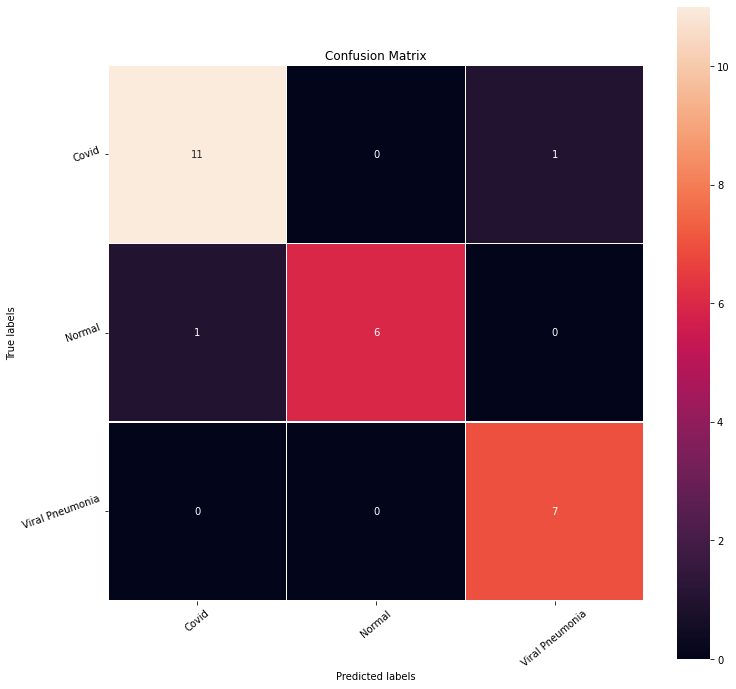

In [81]:
#Probablities for each category
y_pred=model3.predict(X_test_normalized)

#Obtain the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

#Plot the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
#Set the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(encoded.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(encoded.classes_),rotation=20)
plt.show()

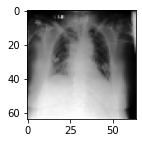

1/1 [==============================] - 0s 341ms/step
Predicted Label ['Covid']
True Label Covid


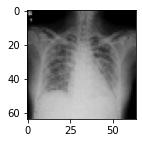

1/1 [==============================] - 0s 26ms/step
Predicted Label ['Covid']
True Label Covid


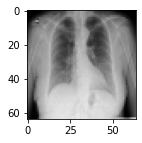

1/1 [==============================] - 0s 27ms/step
Predicted Label ['Covid']
True Label Covid


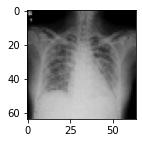

1/1 [==============================] - 0s 27ms/step
Predicted Label ['Covid']
True Label Covid


In [82]:
#Visualize the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', encoded.inverse_transform(model3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   
print('True Label', encoded.inverse_transform(y_test_encoded)[2])                                               

plt.figure(figsize=(2,2))
plt.imshow(X_test[3])
plt.show()
print('Predicted Label', encoded.inverse_transform(model3.predict((X_test_normalized[3].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[3])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[5],)
plt.show()
print('Predicted Label', encoded.inverse_transform(model3.predict((X_test_normalized[5].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[5])                                    

plt.figure(figsize=(2,2))
plt.imshow(X_test[3])
plt.show()
print('Predicted Label', encoded.inverse_transform(model3.predict((X_test_normalized[3].reshape(1,64,64,3)))))
print('True Label', encoded.inverse_transform(y_test_encoded)[6])                                              

In [83]:
#Compare all models
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['99%','86%','99%'],'Validation Accuracy':['91%','83%','96%'],'Test Accuracy':['92%','92%','92%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,99%,91%,92%
1,CNN Model with Data Augmentation,86%,83%,92%
2,Transfer Learning Model,99%,96%,92%


# **Conclusion**

We have successfully created a convultional neural network (CNN) to predict and classify COVID infections based on images of three categories: Normal, COVID, and Viral Pneumonia. The accuracy of the base CNN model and the transfer learning model performed the best at assessing and diagnosing patients with COVID with accuracy scores of 92% on the test data. The best performing model was the transfer learning model.